In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

In [2]:
root_dir = os.getcwd()
print(root_dir)

root_data_dir = os.path.join(root_dir, 'data/torobo/trajs:2000_blocks:3_random')
# root_data_dir = os.path.join(root_dir, 'data/torobo/trajs:360_blocks:3_triangle_v')
print(root_data_dir)

/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network
/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/data/torobo/trajs:2000_blocks:3_random


In [3]:
raw_ds_path = os.path.join(root_data_dir, 'raw.npy')
raw_ds_array = np.load(raw_ds_path, allow_pickle=True, encoding='latin1')
raw_ds_array.shape

(2000, 300, 6)

### Raw data to np array

In [4]:
episodes_list = []

for i in range(0, raw_ds_array.shape[0]):
    timestep_list = []
    for j in range(0, raw_ds_array.shape[1]):
        data_timestep = raw_ds_array[i, j]
        
        timestep = data_timestep[0]
        joint_values = data_timestep[1] #(7, )
        target_A_pos = data_timestep[2]
        target_B_pos = data_timestep[3]
        target_C_pos = data_timestep[4]
        one_hot = data_timestep[5]

        targets_pos = np.concatenate((target_A_pos, target_B_pos, target_C_pos), axis=0) #(9, )
        targets_pos = np.concatenate((targets_pos, one_hot), axis=0) #(13, )

        tmp_list = [timestep]
        for k in range(len(joint_values)):
            tmp_list.append(joint_values[k])
        for k in range(targets_pos.size):
            tmp_list.append(targets_pos[k])

        timestep_list.append(tmp_list)
    episodes_list.append(timestep_list)

In [5]:
torobo_data = np.array(episodes_list)
print(torobo_data.shape)

(2000, 300, 21)


In [6]:
trajs_path = os.path.join(root_data_dir, 'trajs_np.npy')
with open(trajs_path, 'wb') as f:
    np.save(f, torobo_data)

In [7]:
with open(trajs_path, 'rb') as f:
    torobo_data = np.load(f)
print(torobo_data.shape)
print(torobo_data.dtype)

(2000, 300, 21)
float64


In [8]:
steps = torobo_data[:, :, 0]
joint_values = torobo_data[:, :, 1:8]
target_points = torobo_data[:, :, 8:]
print(steps.shape)
print(joint_values.shape)
print(target_points.shape)

(2000, 300)
(2000, 300, 7)
(2000, 300, 13)


### Get velocity and actions

In [9]:
def calculate_vel_act(array, start_idx, end_idx):
    vel_episodes, act_episodes = [], []
    for i in range(array.shape[0]):
        vel_steps, act_steps = [], []
        
        for j in range(array.shape[1]):
            cur_vals = array[i][j][start_idx:end_idx]
            if j != 0:
                prev_vals = array[i][j-1][start_idx:end_idx]
            else: 
                prev_vals = cur_vals

            if j < array.shape[1]-1: # !=
                next_vals = array[i][j+1][start_idx:end_idx]

                vel_steps.append((cur_vals - prev_vals)) #/ (100 / 150))
                act_steps.append(next_vals - cur_vals)
        vel_episodes.append(vel_steps)
        act_episodes.append(act_steps)

    return np.array(vel_episodes), np.array(act_episodes)
    #return np.array(act_episodes)

In [10]:
velocs, acts = calculate_vel_act(joint_values, 0 , 7)

print("Joints:")
print(joint_values.shape)
print(joint_values[2][0][:])
print(joint_values[2][1][:])

print('Velocs:')
print(velocs.shape)
print(velocs[2][0][:])
print(velocs[2][1][:])

print('Acts:')
print(acts.shape)
print(acts[2][0][:])
print(acts[2][1][:])

Joints:
(2000, 300, 7)
[ 1.48034515  1.07410353  1.26089818  1.47143887 -0.45215     1.17809725
  0.61733612]
[ 1.46069595  1.07370586  1.2513528   1.47752495 -0.46288558  1.15569078
  0.6172739 ]
Velocs:
(2000, 299, 7)
[0. 0. 0. 0. 0. 0. 0.]
[-1.96492061e-02 -3.97676079e-04 -9.54538608e-03  6.08607915e-03
 -1.07355759e-02 -2.24064618e-02 -6.22229428e-05]
Acts:
(2000, 299, 7)
[-1.96492061e-02 -3.97676079e-04 -9.54538608e-03  6.08607915e-03
 -1.07355759e-02 -2.24064618e-02 -6.22229428e-05]
[-1.96364207e-02 -3.87610763e-04 -9.54402093e-03  6.05325206e-03
 -1.07300453e-02 -2.24087536e-02 -6.99110268e-05]


### Visualization

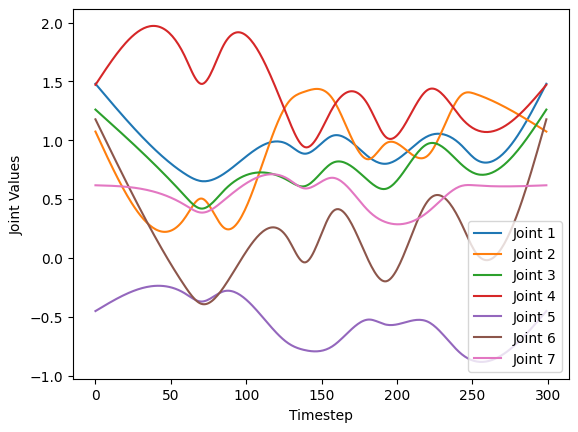

In [11]:
episode_num = 10
sample_vals = joint_values[episode_num, :, :]
# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
for i in range(sample_vals.shape[1]):
    ax.plot(sample_vals[:, i], label=f'Joint {i+1}')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Joint Values')
ax.legend()

# Show the plot
plt.show()

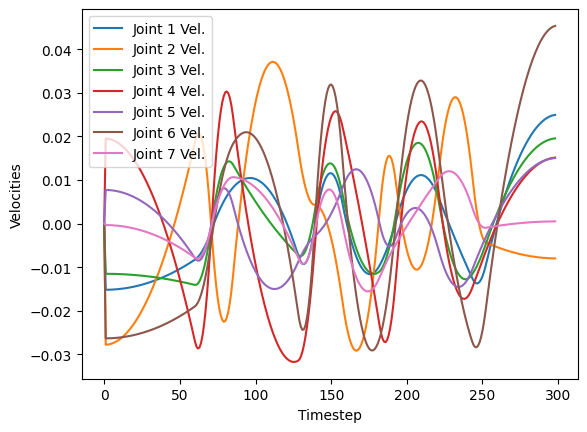

In [12]:
episode_num = 10
sample_vals = velocs[episode_num, :, :]
# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
for i in range(sample_vals.shape[1]):
    ax.plot(sample_vals[:, i], label=f'Joint {i+1} Vel.')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Velocities')
ax.legend()

# Show the plot
plt.show()

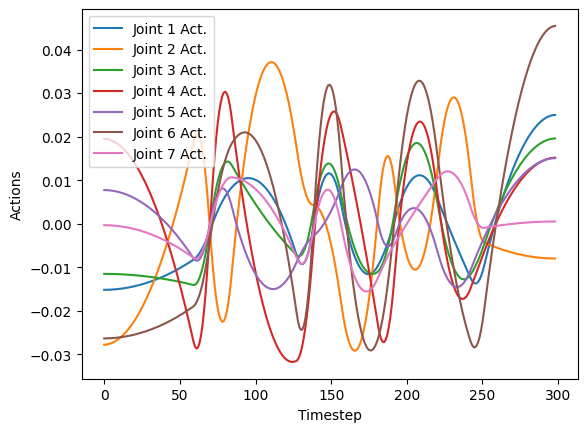

In [13]:
episode_num = 10
sample_vals = acts[episode_num, :, :]
# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
for i in range(sample_vals.shape[1]):
    ax.plot(sample_vals[:, i], label=f'Joint {i+1} Act.')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Actions')
ax.legend()

# Show the plot
plt.show()

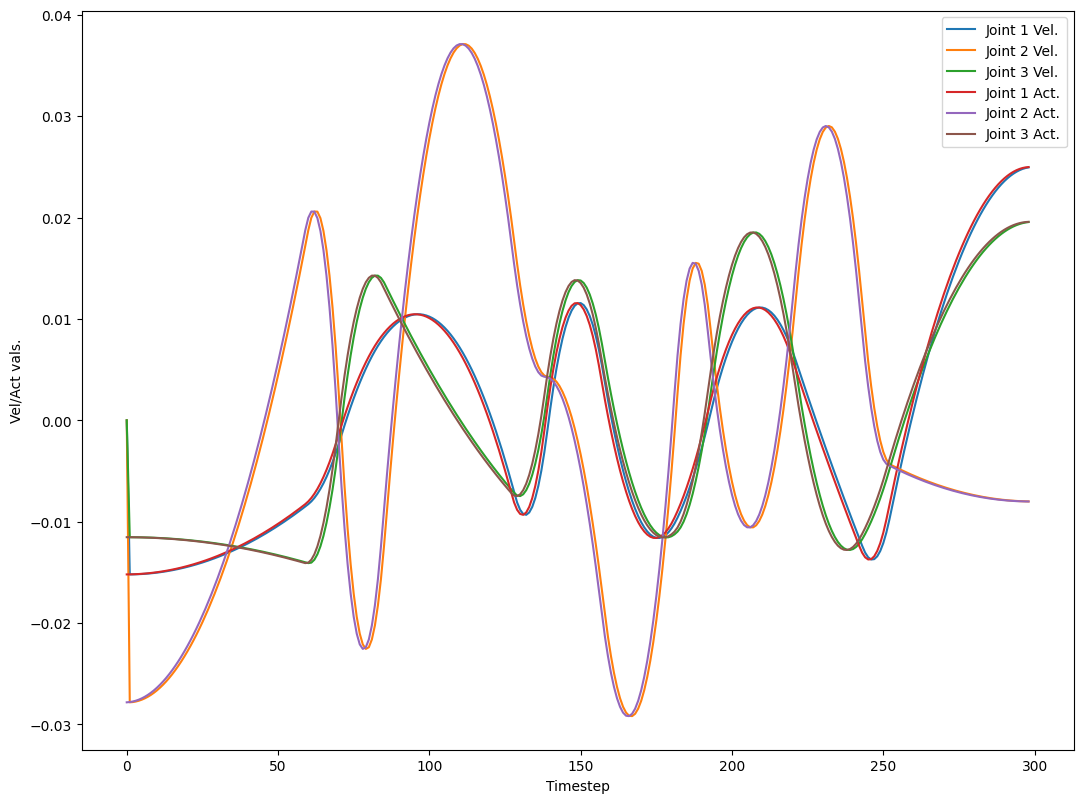

In [14]:
episode_num = 10
sample_vel_vals = velocs[episode_num, :, :]
sample_act_vals = acts[episode_num, :, :]
# Create a figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(12.8, 9.6)

# Plot each column in the array
for i in range(3):
    ax.plot(sample_vel_vals[:, i], label=f'Joint {i+1} Vel.')
for i in range(3):
    ax.plot(sample_act_vals[:, i], label=f'Joint {i+1} Act.')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Vel/Act vals.')
ax.legend()

# Show the plot
plt.show()

### Reducing last step:

In [15]:
print(steps.shape)
print(joint_values.shape)
print(target_points.shape)

steps = steps[:, :-1]
joint_values = joint_values[:, :-1, :]
target_points = target_points[:, :-1, :]

print("After reduction:")
print(steps.shape)
print(joint_values.shape)
print(target_points.shape)

(2000, 300)
(2000, 300, 7)
(2000, 300, 13)
After reduction:
(2000, 299)
(2000, 299, 7)
(2000, 299, 13)


### Mean, STD, Min, Max

In [16]:
print("- Joints -")
print(joint_values.shape)
print(np.mean(joint_values, axis=(0, 1)))
print(np.std(joint_values, axis=(0, 1)))
print(np.max(joint_values, axis=(0, 1)))
print(np.min(joint_values, axis=(0, 1)))

print("- Velocity -")
print(velocs.shape)
print(np.mean(velocs, axis=(0, 1)))
print(np.std(velocs, axis=(0, 1)))
print(np.max(velocs, axis=(0, 1)))
print(np.min(velocs, axis=(0, 1)))

print("- Action -")
print(acts.shape)
print(np.mean(acts, axis=(0, 1)))
print(np.std(acts, axis=(0, 1)))
print(np.max(acts, axis=(0, 1)))
print(np.min(acts, axis=(0, 1)))

- Joints -
(2000, 299, 7)
[ 0.81214506  0.94239686  0.93360097  1.51698363 -0.64044127  0.30817744
  0.52307695]
[0.23945243 0.28696174 0.22157399 0.24411759 0.20726467 0.34474167
 0.20146368]
[ 1.48034515e+00  1.72619233e+00  1.78286287e+00  2.08259428e+00
 -1.96738145e-03  1.17809725e+00  1.08208968e+00]
[ 0.05089921 -0.034023    0.31850406  0.65098248 -1.47890562 -0.52556598
 -0.25411827]
- Velocity -
(2000, 299, 7)
[-9.47619460e-05 -1.83000438e-06 -4.54128756e-05 -2.19040368e-05
 -4.09775564e-05 -1.32698849e-04 -1.82222860e-05]
[0.01253058 0.01174384 0.01069693 0.01485925 0.00823446 0.02211203
 0.00809638]
[0.04208445 0.0463641  0.02729811 0.04346421 0.02658831 0.05342157
 0.03096415]
[-0.03251095 -0.04165989 -0.03252709 -0.04019871 -0.02903101 -0.03803969
 -0.03040447]
- Action -
(2000, 299, 7)
[ 4.06586693e-20  3.86164530e-20  1.98651946e-20 -1.11393615e-20
 -1.94938825e-21  4.60426940e-20  8.44734910e-21]
[0.0126394  0.011748   0.01073188 0.01486773 0.00826882 0.02223196
 0.0081

### Creating final dataset

In [17]:
train_ds = steps[:, :, np.newaxis] #1

train_ds = np.concatenate((train_ds, joint_values), #7
                             axis=2)
train_ds = np.concatenate((train_ds, velocs), #7
                             axis=2)
train_ds = np.concatenate((train_ds, target_points), #13
                             axis=2)
train_ds = np.concatenate((train_ds, acts), #7
                             axis=2)
print(train_ds.shape)

(2000, 299, 35)


In [18]:
train_ds_path = os.path.join(root_data_dir, 'train_ds.npy')
with open(train_ds_path, 'wb') as f:
    np.save(f, train_ds)

### Targets Visualization

Text(0.5, 0, 'Z Label')

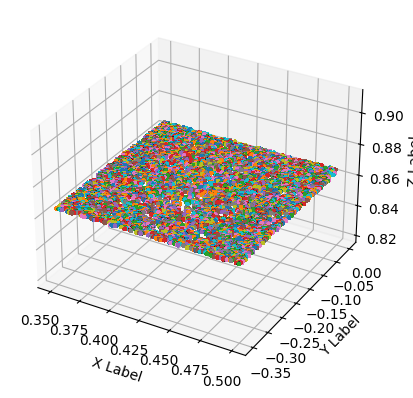

In [19]:
# Create a figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
for i in range(target_points.shape[0]): #range(5): #target_points.shape[0]
    size = 3
    # print(i, target_points[i])
    x = target_points[i, :, 0]
    y = target_points[i, :, 1]
    z = target_points[i, :, 2]
    ax.scatter(x, y, z, s=size)

    x = target_points[i, :, 3]
    y = target_points[i, :, 4]
    z = target_points[i, :, 5]
    ax.scatter(x, y, z, s=size)

    x = target_points[i, :, 6]
    y = target_points[i, :, 7]
    z = target_points[i, :, 8]
    ax.scatter(x, y, z, s=size)

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')